# Imports and Dependencies
Start your notebook by importing any necessary libraries and dependencies that you'll need throughout your code. This could include things like NumPy, Pandas, scikit-learn, or TensorFlow.

In [2]:
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import LinearSVC
from sklearn import metrics, model_selection, tree
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import random
import torch
from torch import nn, optim
import math
from IPython import display
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit

# Data Preparation
Load your dataset into memory, and perform any necessary preprocessing steps. This might include tasks like cleaning the data, handling missing values, feature scaling, encoding categorical variables, and so on.

In [12]:
# Loading the dataset into a Pandas Dataframe - train, test and validate 
    # the data is already divided into train test and validate    
from PIL import Image
import os

# Specify the directory where your images are located
data_dir = '/Users/mac/Desktop/Jupyter/BumbleKite/chest_xray'

In [18]:
from PIL import Image
import os

# Get the list of subdirectories (train, test, validate)
subdirectories = ['train', 'test', 'val']

# Get the list of classes
classes = ['NORMAL', 'PNEUMONIA']

# Create an empty dictionary to store the loaded images
loaded_images = {}

# Iterate over the subdirectories
for subdirectory in subdirectories:
    # Create an empty dictionary for the current subdirectory
    subdirectory_images = {}
    
    # Get the path to the current subdirectory
    subdirectory_path = os.path.join(data_dir, subdirectory)
    
    # Iterate over the classes
    for class_name in classes:
        # Create a list to store images from the current class
        image_list = []
        
        # Get the path to the current class subfolder
        class_dir = os.path.join(subdirectory_path, class_name)
        
        # Iterate over the files in the class subfolder
        for filename in os.listdir(class_dir):
            # Get the path to the current image file
            image_path = os.path.join(class_dir, filename)
            
#             # Load the image using PIL
#             image = Image.open(image_path)
            
            # Append the loaded image to the image_list
            image_list.append(image_path)
        
#         # Close the images after appending them to the list
#         for image in image_list:
#             image.close()
        
        # Add the image_list to the subdirectory_images dictionary with the class name as the key
        subdirectory_images[class_name] = image_list
    
    # Add the subdirectory_images dictionary to the loaded_images dictionary with the subdirectory name as the key
    loaded_images[subdirectory] = subdirectory_images


In [20]:
loaded_images['train']['PNEUMONIA'][0]

'/Users/mac/Desktop/Jupyter/BumbleKite/chest_xray/train/PNEUMONIA/person63_bacteria_306.jpeg'

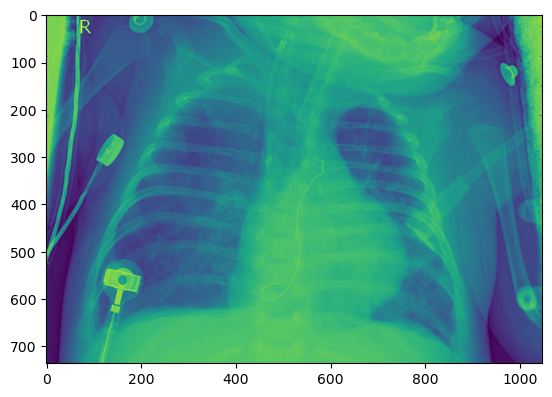

In [31]:
image = Image.open('/Users/mac/Desktop/Jupyter/BumbleKite/chest_xray/train/PNEUMONIA/person63_bacteria_306.jpeg')
plt.imshow(image)

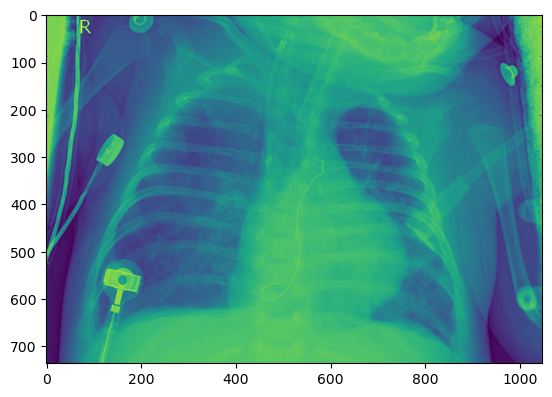

In [32]:
image = Image.open(loaded_images['train']['PNEUMONIA'][0])
plt.imshow(image)

In [42]:
len(loaded_images['train']['PNEUMONIA'])

3875

## Data distribution 

In [14]:

# Calculate the percentage of normal and pneumonia images
for subdirectory in loaded_images:
    subdirectory_images = loaded_images[subdirectory]
    total_images = sum(len(images) for images in subdirectory_images.values())
    
    for class_name in classes:
        class_images = subdirectory_images[class_name]
        class_count = len(class_images)
        class_percentage = (class_count / total_images) * 100
        print(f"Percentage of {class_name} images in {subdirectory}: {class_percentage:.2f}%")

Percentage of NORMAL images in train: 25.71%
Percentage of PNEUMONIA images in train: 74.29%
Percentage of NORMAL images in test: 37.50%
Percentage of PNEUMONIA images in test: 62.50%
Percentage of NORMAL images in val: 50.00%
Percentage of PNEUMONIA images in val: 50.00%


## Model development 

In [2]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
model.eval()

Using cache found in /Users/mac/.cache/torch/hub/pytorch_vision_v0.10.0


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

## Preprocessing of images

In [50]:
from PIL import Image
from torchvision import transforms

# Preprocessing transformations
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

subdirectories = ['train', 'test', 'val']
classes = ['NORMAL', 'PNEUMONIA']

# Create a list to store the input tensors
input_tensors = []

i = 0 

# Process each image in the loop
for subdirectory in subdirectories:
    for class_name in classes:
        while i < 3875:
            i += 1
            # Open the image
            input_image = Image.open(loaded_images[subdirectory][class_name][i])

            # Apply the preprocessing transformations
            input_tensor = preprocess(input_image)

            # Add the input tensor to the list
            input_tensors.append(input_tensor)

# Convert the list of input tensors to a batch tensor
input_batch = torch.stack(input_tensors)

RuntimeError: output with shape [1, 224, 224] doesn't match the broadcast shape [3, 224, 224]

In [ ]:
  # Iterate over the classes
    for class_name in classes:
        # Create a list to store images from the current class
        image_list = []
        
        # Get the path to the current class subfolder
        class_dir = os.path.join(subdirectory_path, class_name)
        
        # Iterate over the files in the class subfolder
        for filename in os.listdir(class_dir):

In [ ]:
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

In [ ]:
# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
probabilities = torch.nn.functional.softmax(output[0], dim=0)
print(probabilities)